## Multi-classification problem


In [6]:
# Uncomment the next line to install packages
!pip install torch torchvision matplotlib pandas seaborn requests 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [8]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [9]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [10]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [11]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [12]:
len(targets)

7291

In [13]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


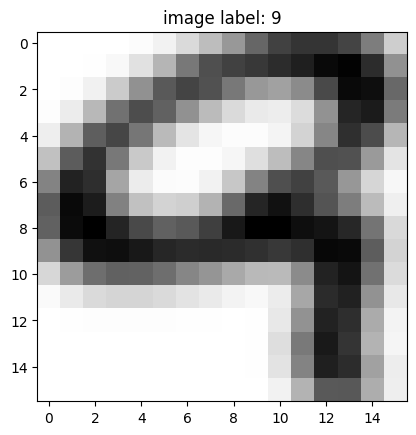

In [14]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [15]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


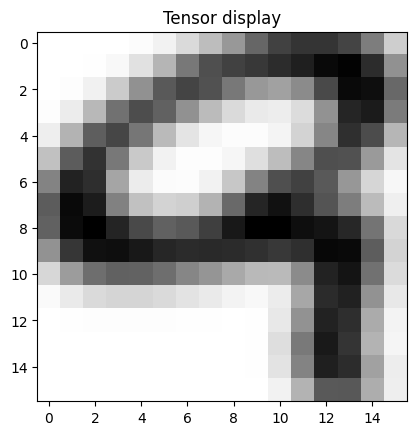

In [16]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [17]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [18]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 80)
        self.l2 = nn.Linear(80, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [19]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=80, bias=True)
  (l2): Linear(in_features=80, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-0.0111,  0.0373,  0.0324,  ...,  0.0139, -0.0281, -0.0426],
        [ 0.0461,  0.0313,  0.0328,  ...,  0.0017,  0.0435, -0.0400],
        [-0.0289, -0.0247, -0.0014,  ...,  0.0395, -0.0340,  0.0383],
        ...,
        [-0.0228, -0.0015, -0.0519,  ...,  0.0207, -0.0563, -0.0531],
        [-0.0041,  0.0051,  0.0531,  ...,  0.0245, -0.0365,  0.0161],
        [ 0.0401,  0.0100, -0.0612,  ...,  0.0198, -0.0451,  0.0305]],
       requires_grad=True)


In [20]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([80, 256])  b :  torch.Size([80])


In [21]:
# Let's explore the forward pass
example_batch_size = 5
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([5, 1, 16, 16])
Impact of the view method torch.Size([5, 256])
Shape of the output torch.Size([5, 10])
Predictions for the first image : tensor([0.1054, 0.1024, 0.0881, 0.1009, 0.0978, 0.1032, 0.1085, 0.0988, 0.1014,
        0.0935])
Sum of all outputs :  tensor(1.0000, grad_fn=<SumBackward0>)


In [22]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([0, 1, 2, 1, 0])
One Hot encoding : tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Train your Model

In [23]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [24]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [25]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0871
Epoch [2/10], Loss: 0.0764
Epoch [3/10], Loss: 0.0637
Epoch [4/10], Loss: 0.0509
Epoch [5/10], Loss: 0.0390
Epoch [6/10], Loss: 0.0296
Epoch [7/10], Loss: 0.0230
Epoch [8/10], Loss: 0.0189
Epoch [9/10], Loss: 0.0164
Epoch [10/10], Loss: 0.0147


Text(0.5, 1.0, 'Visualization of convergence')

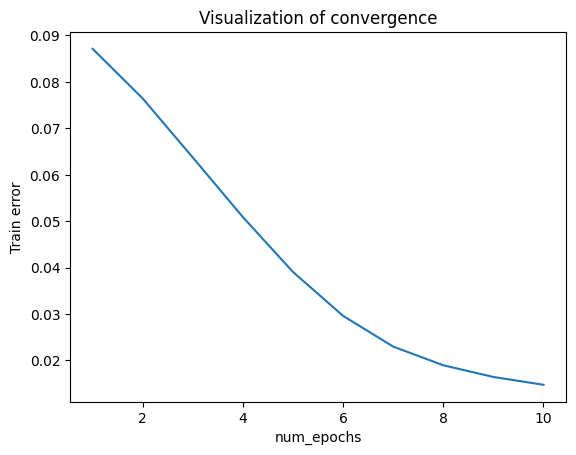

In [26]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [27]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [28]:
accuracy(val_set, model)

Accuracy of the model : 93.42 %


Text(0.5, 1.0, 'Prediction label: 5')

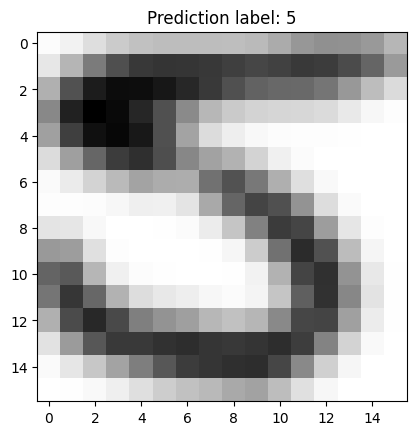

In [29]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

---

---

# Question 1

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [30]:
m = nn.Conv2d(1, 32, 3 , padding = 1)



input = torch.randn(5, 1, 16, 16)
output = m(input)
print(output.shape)
print(output.view(output.size(1), -1).shape)


torch.Size([5, 32, 16, 16])
torch.Size([32, 1280])


In [31]:
class Convolution_1(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_1, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.relu(self.l2(h1_flattened))
        outputs = F.softmax(self.l3(h2), dim=1)
        return outputs


In [32]:
sahbi = Convolution_1()
sahbi = Convolution_1(input_channel=1, output_channel=32, kernel_size=3, height=16, Width=16)
input_tensor = torch.randn(10, 1, 16, 16) 
output = sahbi(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)


tensor([[0.1097, 0.0906, 0.0740, 0.1111, 0.0896, 0.1027, 0.1029, 0.1142, 0.1046,
         0.1007],
        [0.1117, 0.1005, 0.0829, 0.1035, 0.0885, 0.0861, 0.1090, 0.1075, 0.1170,
         0.0932],
        [0.1216, 0.0916, 0.0714, 0.1070, 0.0911, 0.0874, 0.1069, 0.1152, 0.0977,
         0.1102],
        [0.1081, 0.0937, 0.0810, 0.1084, 0.0890, 0.0929, 0.1012, 0.1154, 0.1083,
         0.1020],
        [0.1109, 0.1025, 0.0790, 0.1092, 0.0938, 0.0842, 0.0993, 0.1117, 0.1179,
         0.0916],
        [0.0989, 0.1020, 0.0753, 0.1203, 0.0987, 0.0747, 0.1004, 0.1083, 0.1150,
         0.1063],
        [0.1170, 0.0924, 0.0646, 0.1008, 0.0943, 0.0958, 0.1017, 0.1214, 0.1088,
         0.1034],
        [0.1167, 0.1006, 0.0790, 0.1028, 0.0920, 0.0863, 0.0999, 0.1048, 0.1095,
         0.1081],
        [0.1087, 0.0899, 0.0741, 0.1117, 0.0970, 0.0883, 0.1078, 0.1118, 0.1055,
         0.1052],
        [0.1038, 0.0894, 0.0814, 0.1108, 0.1005, 0.0814, 0.1045, 0.1135, 0.1051,
         0.1096]], grad_fn=<

In [33]:

sahbi = Convolution_1()
sahbi = Convolution_1(input_channel=1, output_channel=32, kernel_size=3, height=16, Width=16)
print(" - What is the type of my_model ?",type(sahbi))
print("="*50)
print(" - Description of the internal of the Network :",sahbi)
print("="*50)
print(" - Content of the first Layer :", sahbi.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", sahbi.l2.weight,)

 - What is the type of my_model ? <class '__main__.Convolution_1'>
 - Description of the internal of the Network : Convolution_1(
  (l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): Linear(in_features=8192, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[-2.1385e-01, -2.6579e-01, -2.9939e-01],
          [-1.4206e-01,  2.9694e-01,  2.3161e-02],
          [ 2.0382e-01, -6.2167e-02,  1.2217e-01]]],


        [[[ 1.8760e-01, -1.1344e-01, -2.1296e-01],
          [-3.0391e-01,  3.0468e-01, -9.8250e-02],
          [-2.9876e-01,  5.0289e-02,  2.0129e-01]]],


        [[[-1.1267e-01, -4.2521e-02, -1.5609e-01],
          [ 9.2669e-02,  6.2690e-02, -4.4099e-02],
          [-1.9229e-01, -3.0754e-01,  2.0188e-01]]],


        [[[-2.4485e-01,  3.7801e-02, -1.1330e-02],
          [-1.2075e-02,  2.5330e-01, -8.7871e-02],
          [-3.0632e-01,  1.7154e-01, -1.8155e-

In [34]:
# Let's explore the forward pass
example_batch_size = 100
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    example_output = sahbi(images )
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([100, 1, 16, 16])
Shape of the output torch.Size([100, 10])
Predictions for the first image : tensor([0.1061, 0.1103, 0.0981, 0.0957, 0.1009, 0.0921, 0.0990, 0.0973, 0.0955,
        0.1050])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [35]:
labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([1, 0, 0, 7, 3, 6, 2, 1, 1, 1, 3, 0, 9, 5, 4, 4, 0, 4, 1, 4, 3, 4, 2, 7,
        6, 8, 2, 1, 0, 3, 3, 1, 0, 1, 1, 0, 7, 1, 0, 0, 7, 5, 3, 8, 2, 0, 9, 9,
        2, 8, 6, 0, 6, 3, 0, 5, 8, 1, 4, 8, 8, 1, 6, 4, 1, 6, 7, 0, 7, 5, 7, 0,
        9, 7, 8, 5, 9, 3, 8, 3, 5, 1, 7, 9, 2, 0, 6, 1, 4, 0, 4, 0, 0, 1, 8, 6,
        0, 0, 2, 0])
One Hot encoding : tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 

# Train the model

In [36]:
from torch.optim import Adam 

In [37]:
optimizer = Adam(sahbi.parameters(), lr=0.001)  # for example, using a learning rate of 0.001

In [38]:
def train(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error


In [39]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(sahbi.parameters(), lr=0.001)

In [40]:
train_error_sahbi_2 = train(10, 5 , criterion, optimizer, sahbi, train_set)
print(train_error_sahbi_2)

Epoch [1/10], Loss: 0.0895
Epoch [2/10], Loss: 0.0890
Epoch [3/10], Loss: 0.0885
Epoch [4/10], Loss: 0.0880
Epoch [5/10], Loss: 0.0875
Epoch [6/10], Loss: 0.0869
Epoch [7/10], Loss: 0.0862
Epoch [8/10], Loss: 0.0854
Epoch [9/10], Loss: 0.0845
Epoch [10/10], Loss: 0.0835
[0.089500979334116, 0.0889974174524347, 0.08850085819760957, 0.08799386980632924, 0.08745578519379084, 0.086855519488454, 0.08617048539221313, 0.08538474040105945, 0.08448030481114986, 0.08346254664783676]


In [41]:
train_error_sahbi = train(num_epochs, batch_size , criterion, optimizer, sahbi, train_set)
print(train_error_sahbi)

Epoch [1/10], Loss: 0.0824
Epoch [2/10], Loss: 0.0812
Epoch [3/10], Loss: 0.0800
Epoch [4/10], Loss: 0.0787
Epoch [5/10], Loss: 0.0775
Epoch [6/10], Loss: 0.0762
Epoch [7/10], Loss: 0.0750
Epoch [8/10], Loss: 0.0737
Epoch [9/10], Loss: 0.0725
Epoch [10/10], Loss: 0.0712
[0.08235967309835061, 0.0811962041196723, 0.07998530096995343, 0.0787456572490433, 0.07748654618238415, 0.07622466204377513, 0.07496889502430956, 0.07371801198925844, 0.0724733421672136, 0.07123513629349575]


Text(0.5, 1.0, 'Visualization of convergence')

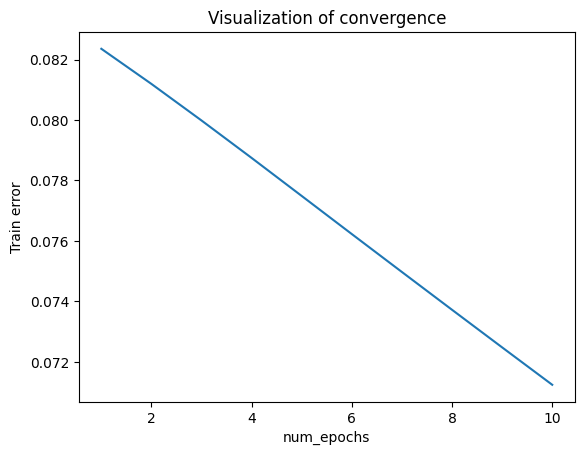

In [42]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error_sahbi)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [43]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images)
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [44]:
accuracy(val_set, sahbi)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Accuracy of the model : 41.29 %


In [45]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
print(image.shape)
output = sahbi(image)
print(output)

torch.Size([1, 1, 16, 16])
tensor([[0.2681, 0.0603, 0.1057, 0.1137, 0.0618, 0.0758, 0.0950, 0.0969, 0.0477,
         0.0750]], grad_fn=<SoftmaxBackward0>)


Text(0.5, 1.0, 'Prediction label: 0')

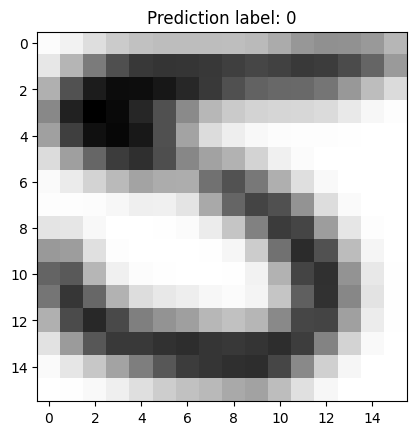

In [46]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = sahbi(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

# Trilayer

In [47]:
class TriLayer(nn.Module):
    
    def __init__(self):
        super(TriLayer, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 80)
        self.l2 = nn.Linear(80, 20)
        self.l3 = nn.Linear(20, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h1 = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        h2 = F.relu(self.l2(h1))
        outputs = F.softmax(self.l3(h2), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [48]:
# We initialize the Model class
Tri = TriLayer() # it calls the init method
print(" - What is the type of my_model ?",type(Tri))
print("="*50)
print(" - Description of the internal of the Network :",Tri)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", my_model.l2.weight,)

 - What is the type of my_model ? <class '__main__.TriLayer'>
 - Description of the internal of the Network : TriLayer(
  (l1): Linear(in_features=256, out_features=80, bias=True)
  (l2): Linear(in_features=80, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-0.0111,  0.0373,  0.0324,  ...,  0.0139, -0.0281, -0.0426],
        [ 0.0461,  0.0313,  0.0328,  ...,  0.0017,  0.0435, -0.0400],
        [-0.0289, -0.0247, -0.0014,  ...,  0.0395, -0.0340,  0.0383],
        ...,
        [-0.0228, -0.0015, -0.0519,  ...,  0.0207, -0.0563, -0.0531],
        [-0.0041,  0.0051,  0.0531,  ...,  0.0245, -0.0365,  0.0161],
        [ 0.0401,  0.0100, -0.0612,  ...,  0.0198, -0.0451,  0.0305]],
       requires_grad=True)
 - Content of the second Layer : Parameter containing:
tensor([[-8.0125e-02,  9.0715e-02,  6.3896e-02, -1.2824e-03, -3.2645e-02,
          5.0659e-02,  2.8975e-02, -4.2740e-03,  3.9929e

In [49]:
# Let's explore the forward pass
example_batch_size = 100
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Transformed shape" , images.view(images.size(0),-1).shape)
    example_output = Tri(images.view(images.size(0),-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([100, 1, 16, 16])
Transformed shape torch.Size([100, 256])
Shape of the output torch.Size([100, 10])
Predictions for the first image : tensor([0.0787, 0.0880, 0.0925, 0.0787, 0.1125, 0.1313, 0.1018, 0.0952, 0.1264,
        0.0949])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [50]:
labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([0, 8, 1, 8, 1, 0, 7, 6, 6, 9, 1, 2, 2, 3, 3, 1, 1, 3, 0, 6, 1, 2, 1, 5,
        7, 6, 1, 2, 5, 0, 7, 0, 2, 0, 5, 3, 1, 4, 1, 7, 6, 9, 0, 2, 9, 1, 3, 8,
        1, 9, 5, 5, 1, 4, 5, 1, 2, 9, 7, 6, 3, 8, 7, 9, 6, 8, 6, 2, 0, 1, 4, 0,
        0, 7, 1, 7, 3, 3, 2, 0, 9, 5, 2, 4, 0, 2, 1, 0, 0, 0, 6, 1, 1, 0, 9, 8,
        5, 4, 1, 9])
One Hot encoding : tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 

In [51]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Tri.parameters(), lr=0.1)

In [52]:
# define a function for training
def train(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images.view(images.size(0),-1)) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [53]:
train_error_tri = train(num_epochs, batch_size , criterion, optimizer, Tri , train_set)
print(train_error_tri)

Epoch [1/10], Loss: 0.0898
Epoch [2/10], Loss: 0.0827
Epoch [3/10], Loss: 0.0642
Epoch [4/10], Loss: 0.0449
Epoch [5/10], Loss: 0.0256
Epoch [6/10], Loss: 0.0169
Epoch [7/10], Loss: 0.0132
Epoch [8/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0099
[0.08977030670270332, 0.08269031939096744, 0.06423526965935386, 0.04492064510937786, 0.025574768266257392, 0.01687421255081062, 0.013218671601628854, 0.011624498788153973, 0.010589116656004005, 0.009898810842867837]


Text(0.5, 1.0, 'Visualization of convergence')

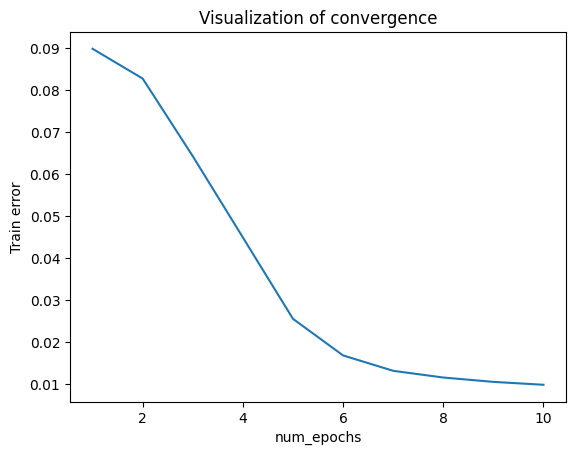

In [54]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error_tri)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [55]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images.view(images.size(0),-1))
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [56]:
accuracy(val_set, Tri)

Accuracy of the model : 94.66 %


In [57]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
print(image.shape)
output = Tri(image.view(image.size(0),-1))
print(output)

torch.Size([1, 1, 16, 16])
tensor([[5.1748e-04, 1.3638e-08, 9.7165e-03, 1.3886e-03, 2.1975e-07, 9.7704e-01,
         6.2233e-04, 6.4347e-06, 1.0711e-02, 2.3837e-06]],
       grad_fn=<SoftmaxBackward0>)


Text(0.5, 1.0, 'Prediction label: 5')

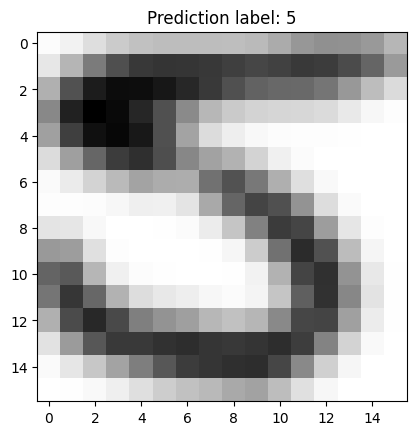

In [58]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Tri(image.view(image.size(0),-1))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

# Modification of the number of Neurons

In [59]:
class Convolution_adapt(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16 , Hidden_neural = 200):
        super(Convolution_adapt, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , Hidden_neural)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(Hidden_neural, 10)  # Correcting the second linear layer

    def forward(self, inputs):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.relu(self.l2(h1_flattened))
        outputs = F.softmax(self.l3(h2), dim=1)
        return outputs

In [60]:
Convolution_256 = Convolution_adapt()
Convolution_256 = Convolution_adapt(input_channel=1, output_channel=32, kernel_size=3, height=16, Width=16 , Hidden_neural = 256)
input_tensor = torch.randn(10, 1, 16, 16) 
output = Convolution_256(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.0875, 0.0979, 0.1043, 0.0918, 0.1012, 0.1023, 0.0953, 0.0985, 0.0922,
         0.1290],
        [0.0826, 0.0897, 0.1202, 0.0922, 0.1099, 0.0968, 0.0878, 0.1070, 0.1052,
         0.1085],
        [0.0798, 0.0981, 0.0892, 0.0989, 0.0967, 0.1099, 0.0936, 0.1072, 0.1160,
         0.1106],
        [0.0906, 0.1052, 0.1077, 0.0886, 0.0921, 0.0975, 0.0984, 0.1048, 0.1085,
         0.1066],
        [0.0909, 0.0964, 0.0990, 0.0932, 0.1062, 0.1001, 0.1030, 0.1080, 0.0874,
         0.1159],
        [0.0936, 0.1009, 0.1098, 0.0901, 0.1014, 0.0885, 0.0876, 0.1086, 0.0984,
         0.1210],
        [0.0778, 0.0981, 0.1086, 0.0937, 0.0931, 0.0962, 0.1138, 0.0967, 0.0972,
         0.1248],
        [0.0875, 0.1055, 0.1087, 0.0944, 0.0851, 0.1031, 0.1003, 0.0991, 0.1001,
         0.1162],
        [0.0812, 0.1022, 0.1017, 0.1047, 0.1058, 0.0975, 0.0958, 0.1011, 0.1004,
         0.1097],
        [0.0868, 0.1112, 0.1103, 0.0924, 0.0964, 0.0954, 0.1138, 0.0971, 0.0786,
         0.1179]], grad_fn=<

In [61]:
print(" - What is the type of my_model ?",type(Convolution_256))
print("="*50)
print(" - Description of the internal of the Network :",Convolution_256)
print("="*50)
print(" - Content of the first Layer :", Convolution_256.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", Convolution_256.l2.weight,)

 - What is the type of my_model ? <class '__main__.Convolution_adapt'>
 - Description of the internal of the Network : Convolution_adapt(
  (l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): Linear(in_features=8192, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[-0.2710, -0.3254, -0.0305],
          [ 0.2738,  0.0978,  0.0049],
          [ 0.3110,  0.1354, -0.2458]]],


        [[[ 0.0759,  0.0743,  0.1595],
          [-0.2052,  0.1579,  0.3249],
          [-0.2431, -0.2857, -0.1485]]],


        [[[ 0.1767,  0.0704, -0.2524],
          [-0.1687,  0.3333,  0.2558],
          [ 0.3060,  0.2072, -0.3019]]],


        [[[-0.3055,  0.1515, -0.1067],
          [ 0.0902, -0.0336,  0.0984],
          [ 0.2084, -0.0754,  0.0621]]],


        [[[-0.0776,  0.0864, -0.1550],
          [ 0.0316,  0.1148, -0.0082],
          [-0.2364,  0.2529, -0.2914]]],


      

In [62]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Convolution_256.parameters(), lr=0.1)

In [63]:
# define a function for training
def train(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [64]:
Train_Convolution_256 = train(num_epochs, batch_size , criterion, optimizer, Convolution_256, train_set)
print(Train_Convolution_256)

Epoch [1/10], Loss: 0.0455
Epoch [2/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0100
Epoch [4/10], Loss: 0.0089
Epoch [5/10], Loss: 0.0080
Epoch [6/10], Loss: 0.0073
Epoch [7/10], Loss: 0.0066
Epoch [8/10], Loss: 0.0061
Epoch [9/10], Loss: 0.0055
Epoch [10/10], Loss: 0.0052
[0.045493319836508235, 0.012854796657931431, 0.010030469453410356, 0.008891138771141935, 0.007992116650699198, 0.007265857053404747, 0.0065788822999044245, 0.006073507521196426, 0.005534494248961504, 0.005230552596618973]


Text(0.5, 1.0, 'Visualization of convergence')

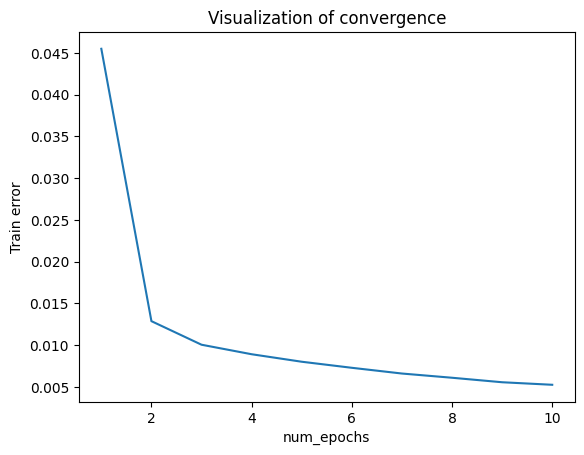

In [65]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), Train_Convolution_256)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")


In [66]:
def accuracy(dataset, model):
    
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images)
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))


In [67]:
accuracy(val_set, Convolution_256)

Accuracy of the model : 96.51 %


Text(0.5, 1.0, 'Prediction label: 5')

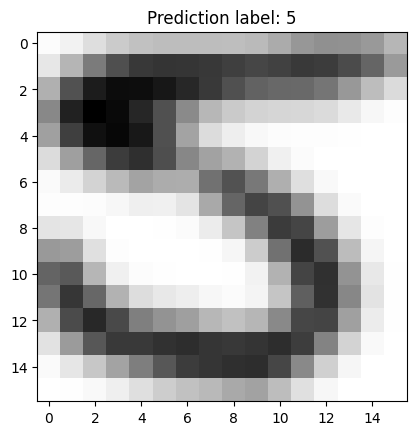

In [68]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Convolution_256(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

In [69]:
Convolution_128 = Convolution_adapt()
Convolution_128 = Convolution_adapt(input_channel=1, output_channel=32, kernel_size=3, height=16, Width=16 , Hidden_neural = 128)
input_tensor = torch.randn(10, 1, 16, 16) 
output = sahbi(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.0776, 0.2828, 0.0932, 0.0895, 0.0854, 0.0612, 0.0893, 0.1080, 0.0349,
         0.0781],
        [0.0666, 0.2554, 0.1205, 0.0654, 0.0906, 0.0524, 0.1244, 0.1065, 0.0453,
         0.0731],
        [0.1053, 0.1717, 0.1341, 0.0912, 0.0959, 0.0664, 0.1103, 0.1016, 0.0451,
         0.0783],
        [0.1615, 0.1698, 0.1100, 0.0903, 0.0829, 0.0746, 0.0931, 0.0842, 0.0468,
         0.0867],
        [0.0623, 0.3010, 0.0848, 0.0903, 0.0873, 0.0709, 0.0935, 0.0977, 0.0479,
         0.0642],
        [0.2431, 0.1237, 0.1240, 0.0674, 0.0759, 0.0500, 0.1209, 0.0849, 0.0363,
         0.0737],
        [0.1424, 0.1606, 0.1063, 0.0819, 0.1020, 0.0602, 0.1012, 0.1087, 0.0523,
         0.0844],
        [0.0962, 0.1809, 0.1111, 0.1018, 0.0927, 0.0608, 0.1202, 0.1126, 0.0423,
         0.0814],
        [0.1789, 0.1705, 0.0831, 0.0892, 0.0867, 0.0645, 0.1097, 0.0974, 0.0329,
         0.0872],
        [0.1213, 0.2070, 0.0991, 0.0895, 0.0785, 0.0657, 0.1327, 0.0912, 0.0423,
         0.0726]], grad_fn=<

In [70]:
print(" - What is the type of my_model ?",type(Convolution_128))
print("="*50)
print(" - Description of the internal of the Network :",Convolution_128)
print("="*50)
print(" - Content of the first Layer :", Convolution_128.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", Convolution_128.l2.weight,)

 - What is the type of my_model ? <class '__main__.Convolution_adapt'>
 - Description of the internal of the Network : Convolution_adapt(
  (l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): Linear(in_features=8192, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[-0.2164, -0.2369, -0.1641],
          [ 0.1885, -0.0696,  0.0012],
          [ 0.1425,  0.2021, -0.2867]]],


        [[[-0.1178, -0.0856, -0.1001],
          [ 0.2395, -0.0166,  0.1343],
          [-0.2157,  0.1180, -0.0203]]],


        [[[-0.2342, -0.1369, -0.2973],
          [ 0.0969,  0.2244, -0.1010],
          [-0.3160, -0.0407, -0.0365]]],


        [[[-0.1476,  0.1861,  0.2110],
          [ 0.2410, -0.2352, -0.0459],
          [-0.3322, -0.0085, -0.1572]]],


        [[[ 0.1397,  0.2149, -0.0633],
          [ 0.0870, -0.2212, -0.1721],
          [ 0.0814,  0.0063,  0.1637]]],


      

In [71]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Convolution_128.parameters(), lr=0.1)

In [72]:
# define a function for training
def train(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [73]:
train_error_Convolution_128 = train(num_epochs, batch_size , criterion, optimizer, Convolution_128, train_set)
print(train_error_Convolution_128)

Epoch [1/10], Loss: 0.0557
Epoch [2/10], Loss: 0.0141
Epoch [3/10], Loss: 0.0105
Epoch [4/10], Loss: 0.0091
Epoch [5/10], Loss: 0.0084
Epoch [6/10], Loss: 0.0074
Epoch [7/10], Loss: 0.0072
Epoch [8/10], Loss: 0.0065
Epoch [9/10], Loss: 0.0060
Epoch [10/10], Loss: 0.0057
[0.05572744066919164, 0.0141205657593567, 0.010523194494144843, 0.009102524837128898, 0.00835944310892316, 0.007439339598284675, 0.007159115939714133, 0.006522430448071544, 0.0059557544551727595, 0.00572106584075536]


Text(0.5, 1.0, 'Visualization of convergence')

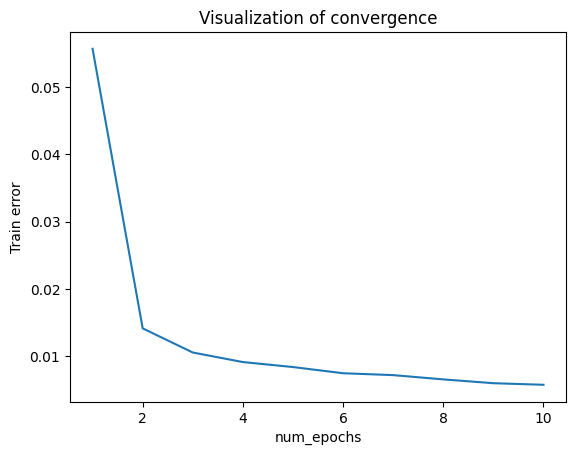

In [74]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error_Convolution_128)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

Accuracy of the model : 96.20 %


Text(0.5, 1.0, 'Prediction label: 5')

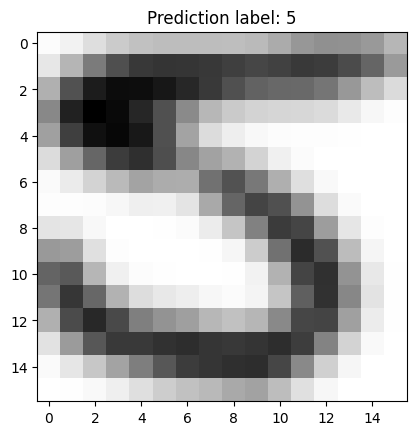

In [75]:
accuracy(val_set, Convolution_128)
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Convolution_128(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

# Use of the Drop Out

In [76]:
class Convolution_drop(nn.Module):
    
    def __init__(self, input_channel=1, output_channel=32, kernel_size=3, height=16, width=16, hidden_neural=256, dropout_rate=0.5):
        super(Convolution_drop, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size, padding=1)
        self.l2 = nn.Linear(output_channel * height * width, hidden_neural)
        self.l3 = nn.Linear(hidden_neural, 10)
        self.dropout = nn.Dropout(dropout_rate)  # Initialize dropout layer

    def forward(self, inputs):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h1_dropped = self.dropout(h1_flattened)  # Apply dropout after flattening (optional placement)
        h2 = F.relu(self.l2(h1_dropped))
        h2_dropped = self.dropout(h2)  # Apply dropout after the first fully connected layer
        outputs = F.softmax(self.l3(h2_dropped), dim=1)
        return outputs

In [77]:
Model_drop = Convolution_drop(input_channel=1, output_channel=32, kernel_size=3, height=16, width=16 , hidden_neural = 256 , dropout_rate = 0.5)

In [78]:
input_tensor = torch.randn(10, 1, 16, 16) 
output = Model_drop(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.0686, 0.1014, 0.0937, 0.0797, 0.1610, 0.1259, 0.1005, 0.0846, 0.0936,
         0.0911],
        [0.1009, 0.0754, 0.1242, 0.0986, 0.1161, 0.0839, 0.0855, 0.0910, 0.1136,
         0.1107],
        [0.0878, 0.0909, 0.0872, 0.1085, 0.0946, 0.1146, 0.1196, 0.0902, 0.0806,
         0.1261],
        [0.0847, 0.0643, 0.1042, 0.1031, 0.1077, 0.1269, 0.1028, 0.0838, 0.1225,
         0.1000],
        [0.0915, 0.0947, 0.1250, 0.0985, 0.0956, 0.1268, 0.0705, 0.0929, 0.1030,
         0.1016],
        [0.0820, 0.0921, 0.1274, 0.1050, 0.0981, 0.1500, 0.0781, 0.0870, 0.1279,
         0.0524],
        [0.0928, 0.0690, 0.1032, 0.0860, 0.1337, 0.1156, 0.1061, 0.0734, 0.1353,
         0.0851],
        [0.0856, 0.0745, 0.0982, 0.1119, 0.1107, 0.1178, 0.1077, 0.0916, 0.0970,
         0.1050],
        [0.1100, 0.0645, 0.1307, 0.1015, 0.1194, 0.1442, 0.0640, 0.0547, 0.1173,
         0.0938],
        [0.0644, 0.0885, 0.1036, 0.0990, 0.1118, 0.0913, 0.1269, 0.0724, 0.1426,
         0.0995]], grad_fn=<

In [79]:
print(" - What is the type of my_model ?",type(Model_drop))
print("="*50)
print(" - Description of the internal of the Network :",Model_drop)
print("="*50)
print(" - Content of the first Layer :", Model_drop.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", Model_drop.l2.weight,)

 - What is the type of my_model ? <class '__main__.Convolution_drop'>
 - Description of the internal of the Network : Convolution_drop(
  (l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): Linear(in_features=8192, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[ 2.5364e-01, -2.8686e-01, -1.8543e-01],
          [-8.3240e-02, -1.4339e-02, -1.3872e-01],
          [ 1.9886e-01, -1.0470e-01,  6.0872e-02]]],


        [[[-2.7079e-01, -1.6575e-01, -1.6413e-01],
          [-1.8072e-01,  1.4991e-01,  2.1050e-01],
          [-1.4821e-01, -2.5871e-01, -9.0848e-02]]],


        [[[-2.6952e-01,  1.8068e-01,  1.1128e-01],
          [ 2.2282e-01,  6.5898e-02, -1.7751e-01],
          [-8.7436e-02, -1.4105e-01,  2.3965e-01]]],


        [[[-3.2771e-01,  1.6610e-01, -1.8684e-01],
          [-1.5454e-01, -8.9783e-03,  9.2709e-02

In [80]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Model_drop.parameters(), lr=0.1)

In [81]:
train_error_drop = train(num_epochs, batch_size , criterion, optimizer, Model_drop, train_set)
print(train_error_drop)

Epoch [1/10], Loss: 0.0527
Epoch [2/10], Loss: 0.0182
Epoch [3/10], Loss: 0.0136
Epoch [4/10], Loss: 0.0118
Epoch [5/10], Loss: 0.0112
Epoch [6/10], Loss: 0.0097
Epoch [7/10], Loss: 0.0097
Epoch [8/10], Loss: 0.0091
Epoch [9/10], Loss: 0.0087
Epoch [10/10], Loss: 0.0081
[0.05272418337195024, 0.01817327427814274, 0.013639261620003255, 0.011810545312357078, 0.01118020804561576, 0.009736512963384777, 0.009725855367882568, 0.00913387553283617, 0.00870619823200534, 0.008078083315136101]


Text(0.5, 1.0, 'Visualization of convergence')

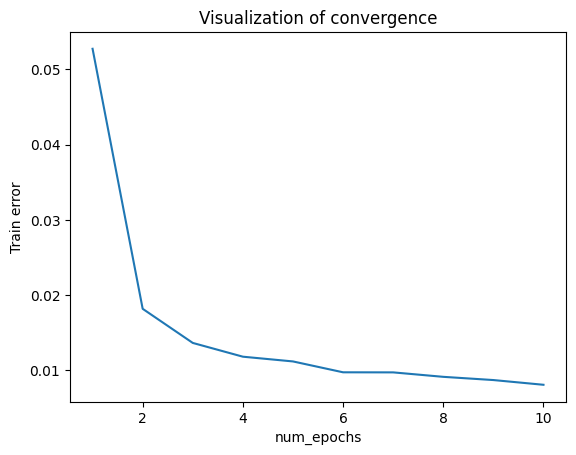

In [82]:
plt.plot(range(1, num_epochs+1), train_error_drop)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [83]:
accuracy(val_set, Model_drop)

Accuracy of the model : 95.89 %


Text(0.5, 1.0, 'Prediction label: 5')

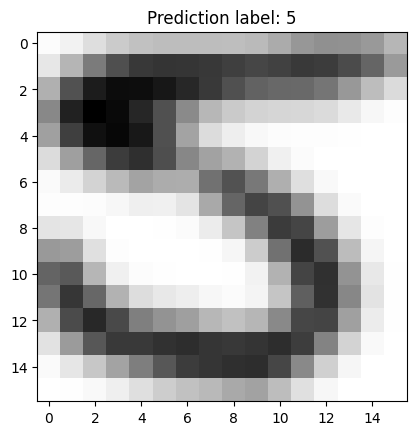

In [84]:

val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Model_drop(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

In [85]:
Model_drop_1 = Convolution_drop(input_channel=1, output_channel=32, kernel_size=3, height=16, width=16 , hidden_neural = 256 , dropout_rate = 0.8)

In [86]:
input_tensor = torch.randn(10, 1, 16, 16) 
output = Model_drop_1(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.1135, 0.3018, 0.0892, 0.0662, 0.0292, 0.0400, 0.0695, 0.0949, 0.1454,
         0.0503],
        [0.1115, 0.1172, 0.0956, 0.0851, 0.2687, 0.0533, 0.0592, 0.0636, 0.0922,
         0.0536],
        [0.0782, 0.1153, 0.1202, 0.1436, 0.1336, 0.0508, 0.0487, 0.1175, 0.0577,
         0.1343],
        [0.1474, 0.0474, 0.2248, 0.1282, 0.0664, 0.0676, 0.0989, 0.0398, 0.1392,
         0.0403],
        [0.0595, 0.0786, 0.0663, 0.2058, 0.1231, 0.0577, 0.1527, 0.1088, 0.1020,
         0.0454],
        [0.1133, 0.0462, 0.2153, 0.0712, 0.1093, 0.0362, 0.0563, 0.0642, 0.1888,
         0.0992],
        [0.0499, 0.0675, 0.0826, 0.1116, 0.1083, 0.0886, 0.1253, 0.0751, 0.1773,
         0.1138],
        [0.1116, 0.0705, 0.1215, 0.0388, 0.0776, 0.0614, 0.2442, 0.0487, 0.1436,
         0.0819],
        [0.0737, 0.0511, 0.0920, 0.1556, 0.1524, 0.0381, 0.2420, 0.0544, 0.0647,
         0.0759],
        [0.0213, 0.0816, 0.0957, 0.0756, 0.2496, 0.0535, 0.0379, 0.0716, 0.2187,
         0.0944]], grad_fn=<

In [87]:
print(" - What is the type of my_model ?",type(Model_drop_1))
print("="*50)
print(" - Description of the internal of the Network :",Model_drop_1)
print("="*50)
print(" - Content of the first Layer :", Model_drop_1.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", Model_drop_1.l2.weight,)

 - What is the type of my_model ? <class '__main__.Convolution_drop'>
 - Description of the internal of the Network : Convolution_drop(
  (l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): Linear(in_features=8192, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[ 2.1276e-01,  3.2670e-01, -1.4681e-01],
          [-2.3387e-01,  2.0451e-01, -2.5219e-01],
          [ 8.4457e-02,  3.0082e-01,  1.7572e-01]]],


        [[[-2.2603e-01, -2.1023e-01,  2.1474e-01],
          [ 1.2258e-01, -2.1534e-01, -1.9317e-01],
          [ 1.3978e-01,  5.6203e-02, -1.2763e-01]]],


        [[[ 3.3049e-01, -2.2597e-01, -1.9985e-01],
          [-4.2328e-02, -1.8060e-01,  3.1604e-01],
          [-9.2091e-02,  2.8546e-01, -7.8355e-02]]],


        [[[ 1.2547e-01,  2.8472e-02, -1.7914e-01],
          [-2.7780e-01, -3.3002e-01,  6.3762e-04

In [88]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Model_drop_1.parameters(), lr=0.1)

In [89]:
train_error_drop_1 = train(num_epochs, batch_size , criterion, optimizer, Model_drop_1, train_set)
print(train_error_drop_1)

Epoch [1/10], Loss: 0.0699
Epoch [2/10], Loss: 0.0389
Epoch [3/10], Loss: 0.0295
Epoch [4/10], Loss: 0.0270
Epoch [5/10], Loss: 0.0236
Epoch [6/10], Loss: 0.0215
Epoch [7/10], Loss: 0.0204
Epoch [8/10], Loss: 0.0190
Epoch [9/10], Loss: 0.0185
Epoch [10/10], Loss: 0.0177
[0.0698787551450853, 0.0388732610415657, 0.029473971400332224, 0.027023053490387736, 0.023582843601486072, 0.021529319112555418, 0.020374421066247792, 0.0189815961054753, 0.018486458770934144, 0.01769882488327973]


Text(0.5, 1.0, 'Visualization of convergence')

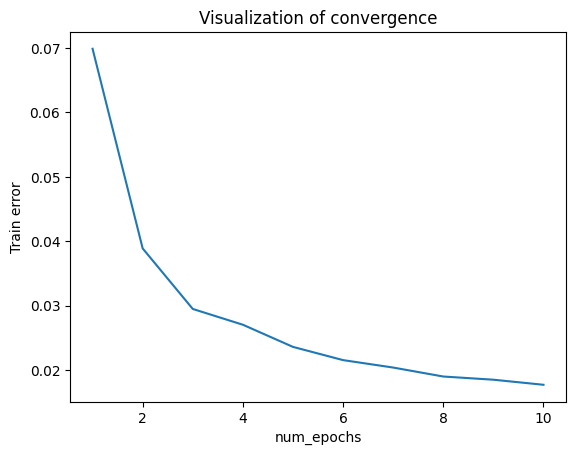

In [90]:
plt.plot(range(1, num_epochs+1), train_error_drop_1)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [91]:
accuracy(val_set, Model_drop)

Accuracy of the model : 95.27 %


Text(0.5, 1.0, 'Prediction label: 5')

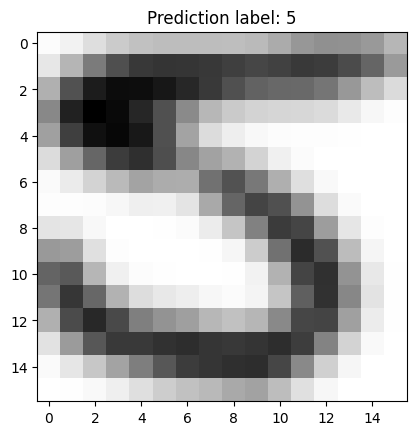

In [92]:

val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Model_drop_1(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

---

In [93]:
class Bilayer(nn.Module):
    
    def __init__(self , first_layer = 256):
        super(Bilayer, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, first_layer)
        self.l2 = nn.Linear(first_layer, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [94]:
Bi_layer_256 = Bilayer(256)

In [95]:
# Let's explore the forward pass
example_batch_size = 5
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = Bi_layer_256(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break


Original tensor shape torch.Size([5, 1, 16, 16])
Impact of the view method torch.Size([5, 256])
Shape of the output torch.Size([5, 10])
Predictions for the first image : tensor([0.1149, 0.0967, 0.1103, 0.0939, 0.0920, 0.0895, 0.0894, 0.1119, 0.0980,
        0.1034])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [96]:
input_tensor = torch.randn(10, 1, 16, 16) 
output = Bi_layer_256(input_tensor.view(input_tensor.size(0),-1))
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.1192, 0.0983, 0.1230, 0.1199, 0.0730, 0.0892, 0.0676, 0.1137, 0.0573,
         0.1387],
        [0.1089, 0.0813, 0.1400, 0.1080, 0.0867, 0.1070, 0.0696, 0.1049, 0.0567,
         0.1370],
        [0.0899, 0.0600, 0.1628, 0.1263, 0.0954, 0.0692, 0.1034, 0.1134, 0.0629,
         0.1167],
        [0.0938, 0.0942, 0.1125, 0.1258, 0.0803, 0.0725, 0.0998, 0.1261, 0.0769,
         0.1180],
        [0.1113, 0.0922, 0.1130, 0.1159, 0.1065, 0.0763, 0.0693, 0.1196, 0.0663,
         0.1295],
        [0.1085, 0.0900, 0.1410, 0.1127, 0.0995, 0.0717, 0.0567, 0.0964, 0.0708,
         0.1527],
        [0.1270, 0.0744, 0.1171, 0.1042, 0.0885, 0.0948, 0.0654, 0.1165, 0.1063,
         0.1058],
        [0.0864, 0.0477, 0.1470, 0.1169, 0.1323, 0.0754, 0.0649, 0.1132, 0.0608,
         0.1554],
        [0.0708, 0.0878, 0.1073, 0.0873, 0.0813, 0.0770, 0.0865, 0.1203, 0.1112,
         0.1704],
        [0.0965, 0.1001, 0.1544, 0.1059, 0.1107, 0.0670, 0.0713, 0.1110, 0.0589,
         0.1243]], grad_fn=<

In [97]:
print(" - What is the type of my_model ?",type(Bi_layer_256))
print("="*50)
print(" - Description of the internal of the Network :",Bi_layer_256)
print("="*50)
print(" - Content of the first Layer :", Bi_layer_256.l1.weight,)
print("="*50)
print(" - Content of the second Layer :", Bi_layer_256.l2.weight,)

 - What is the type of my_model ? <class '__main__.Bilayer'>
 - Description of the internal of the Network : Bilayer(
  (l1): Linear(in_features=256, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-0.0371,  0.0330,  0.0100,  ...,  0.0221, -0.0435,  0.0463],
        [ 0.0042, -0.0073,  0.0128,  ...,  0.0565, -0.0561, -0.0084],
        [-0.0344, -0.0380, -0.0577,  ...,  0.0339, -0.0140, -0.0301],
        ...,
        [-0.0363,  0.0197,  0.0548,  ...,  0.0002, -0.0569, -0.0326],
        [ 0.0263,  0.0121,  0.0157,  ..., -0.0240,  0.0540,  0.0376],
        [ 0.0002, -0.0317, -0.0513,  ...,  0.0339,  0.0558, -0.0577]],
       requires_grad=True)
 - Content of the second Layer : Parameter containing:
tensor([[-0.0116,  0.0063, -0.0370,  ..., -0.0398,  0.0152,  0.0222],
        [-0.0467,  0.0536,  0.0095,  ...,  0.0035, -0.0518,  0.0582],
        [-0.0142, -0.0092,  0.0002,  ...,  0.0559

In [98]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Bi_layer_256.parameters(), lr=0.1)

In [99]:
def train_Conv(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [100]:
def train_linear(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images.view(images.size(0),-1)) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [101]:
train_error_bi_256 = train_linear(num_epochs, batch_size , criterion, optimizer, Bi_layer_256, train_set)
print(train_error_bi_256)

Epoch [1/10], Loss: 0.0750
Epoch [2/10], Loss: 0.0443
Epoch [3/10], Loss: 0.0244
Epoch [4/10], Loss: 0.0168
Epoch [5/10], Loss: 0.0137
Epoch [6/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0102
Epoch [9/10], Loss: 0.0097
Epoch [10/10], Loss: 0.0092
[0.07496926544855032, 0.044344094481396784, 0.024440640457663317, 0.016770581936289095, 0.013721785040361272, 0.012042912375315334, 0.011047200413718964, 0.01024653150101283, 0.00969657719607009, 0.009204827375810208]


In [102]:
optimizer = Adam(Bi_layer_256.parameters(), lr=0.001)

In [103]:
train_error_bi_256_2 = train_linear(num_epochs, batch_size , criterion, optimizer, Bi_layer_256, train_set)
print(train_error_bi_256_2)

Epoch [1/10], Loss: 0.0104
Epoch [2/10], Loss: 0.0078
Epoch [3/10], Loss: 0.0069
Epoch [4/10], Loss: 0.0054
Epoch [5/10], Loss: 0.0048
Epoch [6/10], Loss: 0.0040
Epoch [7/10], Loss: 0.0038
Epoch [8/10], Loss: 0.0035
Epoch [9/10], Loss: 0.0028
Epoch [10/10], Loss: 0.0026
[0.010446232324629549, 0.0077841708280432355, 0.006861267226572118, 0.005438998126508686, 0.004791374299222852, 0.003981191582111643, 0.003770988668795595, 0.003489793903547987, 0.002837340586028525, 0.0026292115671771817]


Text(0.5, 1.0, 'Visualization of convergence')

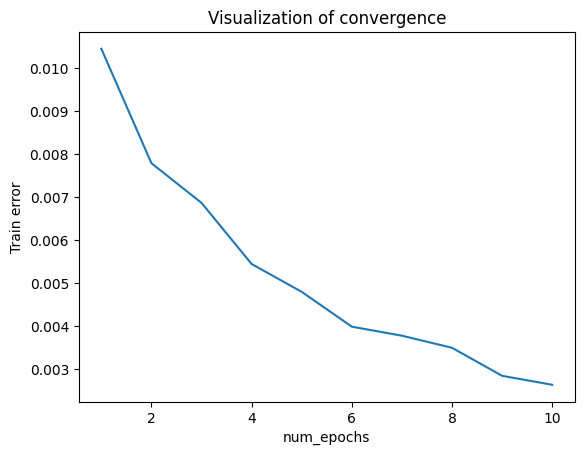

In [104]:
plt.plot(range(1, num_epochs+1), train_error_bi_256_2)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

Text(0.5, 1.0, 'Visualization of convergence')

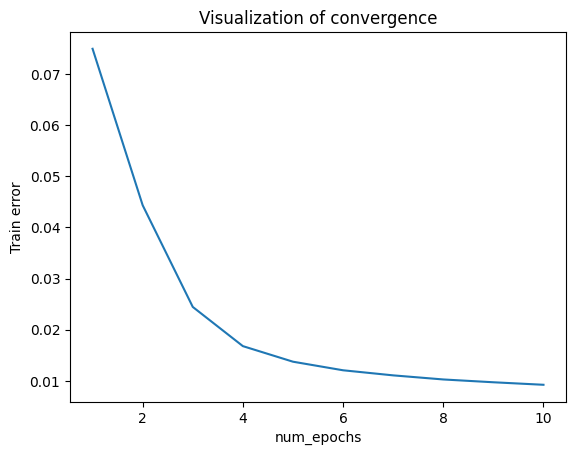

In [105]:
plt.plot(range(1, num_epochs+1), train_error_bi_256)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [106]:
def accuracy_cov(dataset, model):
    
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images)
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [107]:
def accuracy_linear(dataset, model):
    
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images.view(images.size(0),-1))
        #   _, predicted = torch.max(outputs.data, 1)  
            _, predicted = torch.max(outputs.detach(), 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [108]:
accuracy_linear(val_set, Bi_layer_256)

Accuracy of the model : 97.75 %


Text(0.5, 1.0, 'Prediction label: 5')

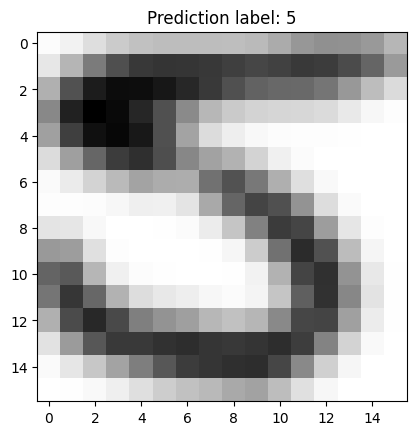

In [109]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Bi_layer_256(image.view(image.size(0),-1))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

In [110]:
Bi_layer_10 = Bilayer(10)

In [111]:
example_batch_size = 5
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = Bi_layer_10(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break


Original tensor shape torch.Size([5, 1, 16, 16])
Impact of the view method torch.Size([5, 256])
Shape of the output torch.Size([5, 10])
Predictions for the first image : tensor([0.1382, 0.1111, 0.1062, 0.1074, 0.0830, 0.0771, 0.0983, 0.1079, 0.0901,
        0.0805])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [112]:
num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(Bi_layer_10.parameters(), lr=0.1)

In [113]:
train_error_bi_10 = train_linear(num_epochs, batch_size , criterion, optimizer, Bi_layer_10, train_set)
print(train_error_bi_10)

Epoch [1/10], Loss: 0.0800
Epoch [2/10], Loss: 0.0654
Epoch [3/10], Loss: 0.0541
Epoch [4/10], Loss: 0.0384
Epoch [5/10], Loss: 0.0264
Epoch [6/10], Loss: 0.0207
Epoch [7/10], Loss: 0.0178
Epoch [8/10], Loss: 0.0160
Epoch [9/10], Loss: 0.0148
Epoch [10/10], Loss: 0.0138
[0.08000727354393644, 0.06540423561586065, 0.05413696850650001, 0.03839543984465613, 0.026390464525660108, 0.020731227047169027, 0.017797772746252993, 0.016046900679563488, 0.014799034432123045, 0.013758690806162141]


Text(0.5, 1.0, 'Visualization of convergence')

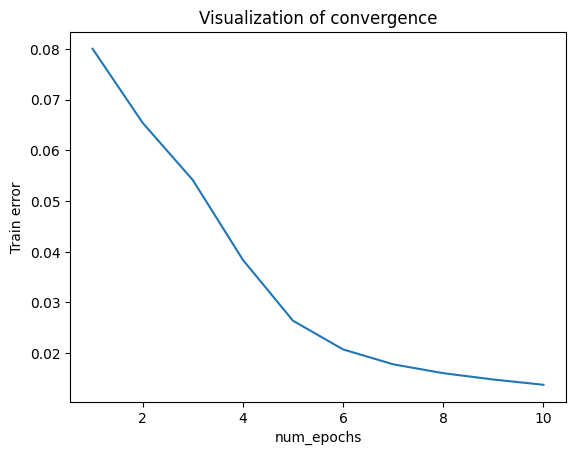

In [114]:
plt.plot(range(1, num_epochs+1), train_error_bi_10)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [115]:
accuracy_linear(val_set, Bi_layer_10)

Accuracy of the model : 91.71 %


Text(0.5, 1.0, 'Prediction label: 5')

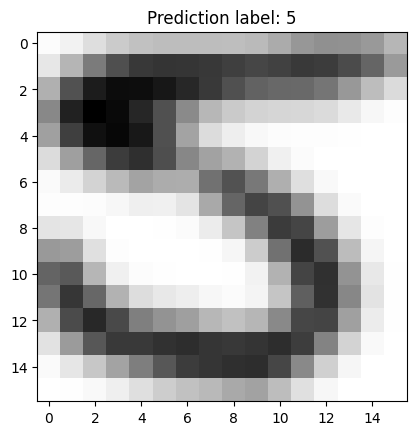

In [116]:
val_index = 66

(image, label) = val_set[val_index]
image = torch.unsqueeze(image, 0)
output = Bi_layer_10(image.view(image.size(0),-1))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

---

---

# USING ADAM

---

---

In [117]:
class Bilayer(nn.Module):
    
    def __init__(self , first_layer = 256):
        super(Bilayer, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, first_layer)
        self.l2 = nn.Linear(first_layer, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [118]:
Bi_layer_256 = Bilayer(256)

In [119]:
# Let's explore the forward pass
example_batch_size = 5
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = Bi_layer_256(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break


Original tensor shape torch.Size([5, 1, 16, 16])
Impact of the view method torch.Size([5, 256])
Shape of the output torch.Size([5, 10])
Predictions for the first image : tensor([0.0852, 0.0985, 0.0931, 0.1047, 0.0995, 0.1084, 0.0922, 0.1143, 0.1088,
        0.0952])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [120]:
from torch.optim import Adam

num_epochs = 10
batch_size = 5

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = Adam(Bi_layer_256.parameters(), lr=0.001)

In [121]:
def train_linear(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images.view(images.size(0),-1)) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [122]:
train_error_bi_256_2 = train_linear(num_epochs, batch_size , criterion, optimizer, Bi_layer_256, train_set)
print(train_error_bi_256_2)

Epoch [1/10], Loss: 0.0177
Epoch [2/10], Loss: 0.0086
Epoch [3/10], Loss: 0.0070
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0051
Epoch [6/10], Loss: 0.0040
Epoch [7/10], Loss: 0.0037
Epoch [8/10], Loss: 0.0032
Epoch [9/10], Loss: 0.0028
Epoch [10/10], Loss: 0.0025
[0.017664487776556072, 0.008634670217887363, 0.006968347021756842, 0.005939436624593765, 0.005065616631332212, 0.004012086713058284, 0.0036682004391936805, 0.0032319676442875973, 0.002810727547852353, 0.002523791533836259]


Text(0.5, 1.0, 'Visualization of convergence')

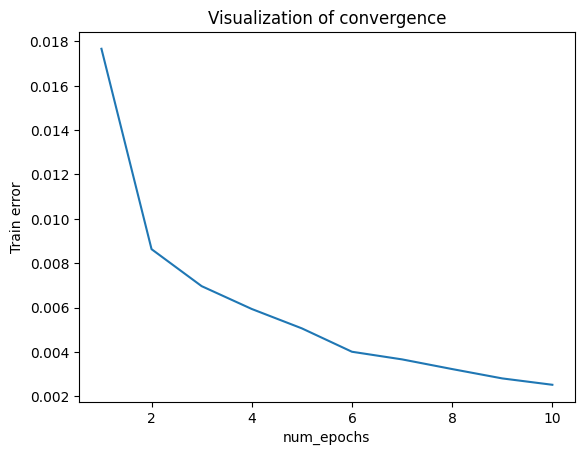

In [123]:
plt.plot(range(1, num_epochs+1), train_error_bi_256_2)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

---

In [124]:
class Convolution_1(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_1, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.relu(self.l2(h1_flattened))
        outputs = F.softmax(self.l3(h2), dim=1)
        return outputs

In [125]:
sahbi = Convolution_1()
sahbi = Convolution_1(input_channel=1, output_channel=32, kernel_size=3, height=16, Width=16)
input_tensor = torch.randn(10, 1, 16, 16) 
output = sahbi(input_tensor)
print(output)
_, predicted_labels = torch.max(output, 1)
print(predicted_labels)

tensor([[0.0970, 0.0960, 0.0831, 0.1328, 0.1102, 0.0891, 0.1058, 0.0915, 0.1091,
         0.0854],
        [0.0910, 0.1154, 0.0828, 0.1135, 0.1046, 0.0895, 0.1008, 0.0930, 0.1083,
         0.1011],
        [0.1109, 0.1136, 0.0738, 0.1233, 0.1130, 0.0850, 0.0964, 0.0859, 0.1159,
         0.0822],
        [0.0970, 0.0974, 0.0796, 0.1267, 0.1121, 0.0958, 0.1066, 0.0902, 0.1023,
         0.0924],
        [0.1004, 0.1046, 0.0819, 0.1354, 0.1041, 0.0899, 0.0931, 0.1026, 0.0986,
         0.0893],
        [0.0903, 0.1166, 0.0836, 0.1114, 0.1220, 0.0869, 0.0962, 0.0874, 0.1087,
         0.0971],
        [0.0948, 0.1052, 0.0730, 0.1370, 0.1037, 0.1036, 0.0936, 0.0994, 0.1078,
         0.0820],
        [0.0974, 0.1103, 0.0911, 0.1122, 0.0967, 0.0978, 0.1015, 0.0931, 0.1033,
         0.0966],
        [0.0890, 0.1068, 0.0846, 0.1290, 0.1085, 0.0995, 0.1059, 0.0998, 0.0931,
         0.0838],
        [0.0906, 0.1093, 0.0785, 0.1225, 0.1132, 0.1052, 0.0909, 0.0927, 0.0999,
         0.0972]], grad_fn=<

In [126]:
example_batch_size = 100
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    example_output = sahbi(images )
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break


Original tensor shape torch.Size([100, 1, 16, 16])
Shape of the output torch.Size([100, 10])
Predictions for the first image : tensor([0.0962, 0.1047, 0.0846, 0.1176, 0.1058, 0.0926, 0.0982, 0.0926, 0.1151,
        0.0926])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [127]:
optimizer = Adam(sahbi.parameters(), lr=0.001)  # for example, using a learning rate of 0.001


In [128]:
def train(num_epochs, batch_size , criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
         
            y_pre = model(images) 
       
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [129]:
train_error_sahbi_2 = train(num_epochs, batch_size , criterion, optimizer, sahbi, train_set)
print(train_error_sahbi_2)


Epoch [1/10], Loss: 0.0168
Epoch [2/10], Loss: 0.0075
Epoch [3/10], Loss: 0.0047
Epoch [4/10], Loss: 0.0037
Epoch [5/10], Loss: 0.0026
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0017
Epoch [8/10], Loss: 0.0015
Epoch [9/10], Loss: 0.0013
Epoch [10/10], Loss: 0.0007
[0.01684726606303261, 0.00753343635880906, 0.004737508444491996, 0.0036871770979832593, 0.0025771275318311766, 0.001823181234758936, 0.001713733832112532, 0.001524366165075478, 0.001270320836238337, 0.0007348618806200008]


Text(0.5, 1.0, 'Visualization of convergence')

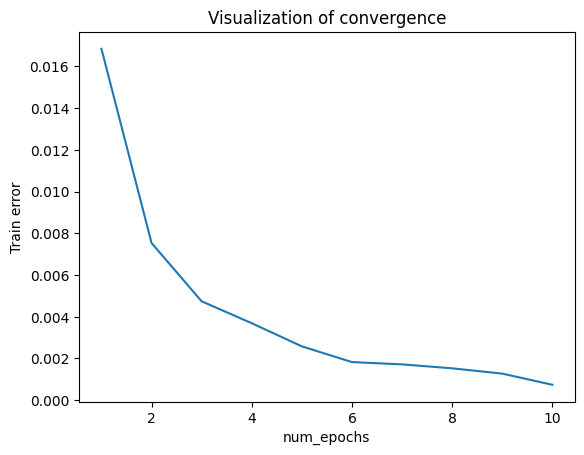

In [130]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error_sahbi_2)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")


In [131]:
accuracy_cov(val_set, sahbi)

Accuracy of the model : 98.30 %


Text(0.5, 1.0, 'Prediction label: 5')

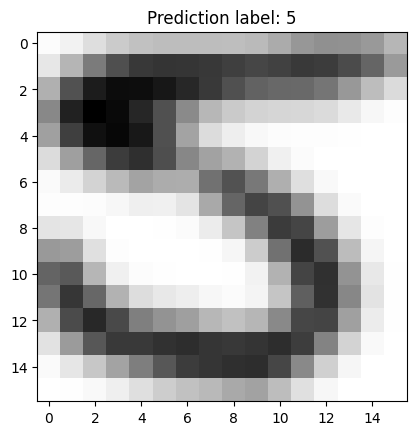

In [132]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

---

---

# BATCH SIZE 

---

---

In [133]:
from torch.optim import SGD

In [134]:
sahbi_batch = Convolution_1()

In [135]:
optimizer = SGD(sahbi_batch.parameters(), lr=0.1)

In [136]:
train_error_sahbi_50 = train(num_epochs, 50 , criterion, optimizer, sahbi_batch, train_set)
print(train_error_sahbi_50)

Epoch [1/10], Loss: 0.0877
Epoch [2/10], Loss: 0.0803
Epoch [3/10], Loss: 0.0708
Epoch [4/10], Loss: 0.0596
Epoch [5/10], Loss: 0.0459
Epoch [6/10], Loss: 0.0322
Epoch [7/10], Loss: 0.0229
Epoch [8/10], Loss: 0.0181
Epoch [9/10], Loss: 0.0156
Epoch [10/10], Loss: 0.0141
[0.08774624286840363, 0.08031065594404938, 0.07082349695265296, 0.05956694735214111, 0.045949216155956235, 0.03217851545972128, 0.022854132298380132, 0.018091219733469187, 0.015630226811238872, 0.014065779737817747]


In [137]:
accuracy_cov(val_set , sahbi_batch)

Accuracy of the model : 93.49 %


In [138]:
train_error_sahbi_100 = train(num_epochs, 100 , criterion, optimizer, sahbi_batch, train_set)
print(train_error_sahbi_100)

Epoch [1/10], Loss: 0.0130
Epoch [2/10], Loss: 0.0126
Epoch [3/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0118
Epoch [5/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0109
Epoch [8/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0102
[0.013035288903241356, 0.012570566598636408, 0.012120800931006667, 0.011803562900361917, 0.011462286378567416, 0.011150716586659356, 0.01088339558336884, 0.010677259252406661, 0.01046195151284337, 0.010216451149123408]


In [139]:
accuracy_cov(val_set , sahbi_batch)

Accuracy of the model : 94.35 %


In [140]:
train_error_sahbi_10 = train(num_epochs, 10 , criterion, optimizer, sahbi_batch, train_set)
print(train_error_sahbi_10)

Epoch [1/10], Loss: 0.0107
Epoch [2/10], Loss: 0.0096
Epoch [3/10], Loss: 0.0089
Epoch [4/10], Loss: 0.0084
Epoch [5/10], Loss: 0.0079
Epoch [6/10], Loss: 0.0076
Epoch [7/10], Loss: 0.0072
Epoch [8/10], Loss: 0.0068
Epoch [9/10], Loss: 0.0066
Epoch [10/10], Loss: 0.0064
[0.010709056154616228, 0.009598912227337065, 0.008916114667902836, 0.008359426453878688, 0.007913510993319045, 0.007600627982402938, 0.007232219875847555, 0.006757855712886378, 0.006581185163436202, 0.006414648324079051]


In [141]:
accuracy_cov(val_set , sahbi_batch)

Accuracy of the model : 96.20 %


---

---

# Learning Rate


---

---

In [418]:
sahbi_learning = Convolution_1()

In [419]:
optimizer_0001 = SGD(sahbi_learning.parameters(), lr=0.001)
optimizer_001 = SGD(sahbi_learning.parameters(), lr=0.01)
optimizer_01 = SGD(sahbi_learning.parameters(), lr=0.1)
optimizer_1 = SGD(sahbi_learning.parameters(), lr=1)
optimizer_10 = SGD(sahbi_learning.parameters(), lr=10)

In [144]:
train_error_sahbi_lr_0001 = train(num_epochs, 5 , criterion, optimizer_0001, sahbi_learning, train_set)
print(train_error_sahbi_lr_0001)

Epoch [1/10], Loss: 0.0899
Epoch [2/10], Loss: 0.0894
Epoch [3/10], Loss: 0.0890
Epoch [4/10], Loss: 0.0885
Epoch [5/10], Loss: 0.0880
Epoch [6/10], Loss: 0.0875
Epoch [7/10], Loss: 0.0869
Epoch [8/10], Loss: 0.0861
Epoch [9/10], Loss: 0.0854
Epoch [10/10], Loss: 0.0845
[0.089897698443383, 0.08941301579276713, 0.08896122671663764, 0.08851260635380923, 0.08801805271456642, 0.08746786376461381, 0.0868558921975392, 0.08614440137520427, 0.08535796809320649, 0.0844948653876782]


In [145]:
accuracy_cov(val_set , sahbi_learning)

Accuracy of the model : 32.15 %


In [146]:
train_error_sahbi_lr_001 = train(num_epochs, 5 , criterion, optimizer_001, sahbi_learning, train_set)
print(train_error_sahbi_lr_001)

Epoch [1/10], Loss: 0.0787
Epoch [2/10], Loss: 0.0672
Epoch [3/10], Loss: 0.0544
Epoch [4/10], Loss: 0.0419
Epoch [5/10], Loss: 0.0323
Epoch [6/10], Loss: 0.0238
Epoch [7/10], Loss: 0.0185
Epoch [8/10], Loss: 0.0158
Epoch [9/10], Loss: 0.0141
Epoch [10/10], Loss: 0.0129
[0.07874922897356267, 0.06717245785829913, 0.054448203338930905, 0.04189559501033126, 0.03225993776053662, 0.023800306544969032, 0.018500097631695123, 0.015762248354282457, 0.014090273286844123, 0.012935196566371196]


In [147]:
accuracy_cov(val_set , sahbi_learning)

Accuracy of the model : 94.04 %


In [420]:
train_error_sahbi_lr_1 = train(num_epochs, 5 , criterion, optimizer_1, sahbi_learning, train_set)
print(train_error_sahbi_lr_1)

Epoch [1/10], Loss: 0.0225
Epoch [2/10], Loss: 0.0086
Epoch [3/10], Loss: 0.0060
Epoch [4/10], Loss: 0.0044
Epoch [5/10], Loss: 0.0035
Epoch [6/10], Loss: 0.0026
Epoch [7/10], Loss: 0.0022
Epoch [8/10], Loss: 0.0020
Epoch [9/10], Loss: 0.0015
Epoch [10/10], Loss: 0.0011
[0.02246576770913697, 0.008603099592091466, 0.005958860602644157, 0.004431784494924187, 0.003490239372153692, 0.002568189363091446, 0.002154767969863742, 0.001972029546949034, 0.0015304072173606864, 0.001099623449428183]


In [421]:
accuracy_cov(val_set , sahbi_learning)

Accuracy of the model : 98.22 %


In [150]:
train_error_sahbi_lr_10 = train(num_epochs, 5 , criterion, optimizer_10, sahbi_learning, train_set)
print(train_error_sahbi_lr_10)

Epoch [1/10], Loss: 0.1755
Epoch [2/10], Loss: 0.1825
Epoch [3/10], Loss: 0.1825
Epoch [4/10], Loss: 0.1825
Epoch [5/10], Loss: 0.1825
Epoch [6/10], Loss: 0.1825
Epoch [7/10], Loss: 0.1825
Epoch [8/10], Loss: 0.1825
Epoch [9/10], Loss: 0.1825
Epoch [10/10], Loss: 0.1825
[0.17553978005016682, 0.18253333398451213, 0.18253333390379733, 0.18253333400934732, 0.18253333395967658, 0.1825333340466002, 0.1825333339969296, 0.18253333394725896, 0.1825333340838531, 0.18253333399072091]


In [151]:
accuracy_cov(val_set , sahbi_learning)

Accuracy of the model : 9.30 %


----

---

# Epochs

---

---

In [152]:
sahbi_epoc = Convolution_1()

In [153]:
optimizer_1 = SGD(sahbi_epoc.parameters(), lr=1)

In [154]:
train_error_sahbi_epo_5 = train(5, 5 , criterion, optimizer_1, sahbi_epoc, train_set)
print(train_error_sahbi_epo_5)

Epoch [1/5], Loss: 0.0237
Epoch [2/5], Loss: 0.0090
Epoch [3/5], Loss: 0.0061
Epoch [4/5], Loss: 0.0050
Epoch [5/5], Loss: 0.0039
[0.023710386653346516, 0.008971404703636455, 0.006137355953829252, 0.004993789673161708, 0.003933717518368123]


In [155]:
accuracy_cov(val_set , sahbi_epoc)

Accuracy of the model : 96.90 %


In [156]:
train_error_sahbi_epo_20 = train(20, 5 , criterion, optimizer_1, sahbi_epoc, train_set)
print(train_error_sahbi_epo_20)

Epoch [1/20], Loss: 0.0030
Epoch [2/20], Loss: 0.0025
Epoch [3/20], Loss: 0.0022
Epoch [4/20], Loss: 0.0016
Epoch [5/20], Loss: 0.0010
Epoch [6/20], Loss: 0.0009
Epoch [7/20], Loss: 0.0006
Epoch [8/20], Loss: 0.0007
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0005
Epoch [14/20], Loss: 0.0006
Epoch [15/20], Loss: 0.0006
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0004
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0004
[0.0029512816154193223, 0.002494585232008877, 0.002189149657979768, 0.0016360201300449518, 0.0010358951207897053, 0.0008676208870090361, 0.0006295010653000015, 0.0006637661903387843, 0.0005165386767433517, 0.0004487465855835044, 0.0004923541299489838, 0.0004203444466085267, 0.0004631831154636227, 0.0005897174873791243, 0.0005824197072996442, 0.00031937303716160064, 0.00030769127526358414, 0.00038875982329373415, 0.00033616770942526176, 0.0003900

In [157]:
accuracy_cov(val_set , sahbi_epoc)

Accuracy of the model : 97.99 %


In [158]:
train_error_sahbi_epo_100 = train(100, 5 , criterion, optimizer_1, sahbi_epoc, train_set)
print(train_error_sahbi_epo_100)

Epoch [1/100], Loss: 0.0003
Epoch [2/100], Loss: 0.0003
Epoch [3/100], Loss: 0.0004
Epoch [4/100], Loss: 0.0003
Epoch [5/100], Loss: 0.0002
Epoch [6/100], Loss: 0.0003
Epoch [7/100], Loss: 0.0002
Epoch [8/100], Loss: 0.0002
Epoch [9/100], Loss: 0.0002
Epoch [10/100], Loss: 0.0002
Epoch [11/100], Loss: 0.0002
Epoch [12/100], Loss: 0.0002
Epoch [13/100], Loss: 0.0002
Epoch [14/100], Loss: 0.0002
Epoch [15/100], Loss: 0.0002
Epoch [16/100], Loss: 0.0002
Epoch [17/100], Loss: 0.0002
Epoch [18/100], Loss: 0.0002
Epoch [19/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0002
Epoch [21/100], Loss: 0.0002
Epoch [22/100], Loss: 0.0002
Epoch [23/100], Loss: 0.0001
Epoch [24/100], Loss: 0.0001
Epoch [25/100], Loss: 0.0001
Epoch [26/100], Loss: 0.0001
Epoch [27/100], Loss: 0.0001
Epoch [28/100], Loss: 0.0001
Epoch [29/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0001
Epoch [32/100], Loss: 0.0001
Epoch [33/100], Loss: 0.0001
Epoch [34/100], Loss: 0.0001
Epoch [35/100], Loss: 0

In [159]:
accuracy_cov(val_set , sahbi_epoc)

Accuracy of the model : 98.30 %


---

# New Loss Function

---

In [306]:
class Convolution_cross(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_cross, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16 ):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.relu(self.l2(h1_flattened))
        outputs = self.l3(h2)
        return outputs
    

In [307]:
cross_conv = Convolution_cross()

In [ ]:
cross_conv = Convolution_cross()
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(cross_conv.parameters(), lr=0.1)


In [317]:
cross_conv_1 = Convolution_cross()

In [318]:
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(cross_conv_1.parameters(), lr=0.1)

In [347]:
def train_Cross_Conv(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()  # Indicates to the network we are in training mode
    
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            
            optimizer.zero_grad()  # Set gradients to 0
            loss.backward()  # Compute gradient
            optimizer.step()  # Update model parameters
            
            epoch_average_loss += loss.item() * images.size(0) / len(dataset)
        
        train_error.append(epoch_average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_average_loss:.4f}')
    
    return train_error

In [310]:
train_error_Cross_1 = train_Cross_Conv(100,10,criterion,optimizer,cross_conv,train_set)

Epoch [1/100], Loss: 0.5025
Epoch [2/100], Loss: 0.1805
Epoch [3/100], Loss: 0.1173
Epoch [4/100], Loss: 0.0834
Epoch [5/100], Loss: 0.0626
Epoch [6/100], Loss: 0.0450
Epoch [7/100], Loss: 0.0337
Epoch [8/100], Loss: 0.0283
Epoch [9/100], Loss: 0.0173
Epoch [10/100], Loss: 0.0132
Epoch [11/100], Loss: 0.0110
Epoch [12/100], Loss: 0.0071
Epoch [13/100], Loss: 0.0048
Epoch [14/100], Loss: 0.0036
Epoch [15/100], Loss: 0.0037
Epoch [16/100], Loss: 0.0044
Epoch [17/100], Loss: 0.0034
Epoch [18/100], Loss: 0.0029
Epoch [19/100], Loss: 0.0026
Epoch [20/100], Loss: 0.0026
Epoch [21/100], Loss: 0.0025
Epoch [22/100], Loss: 0.0020
Epoch [23/100], Loss: 0.0018
Epoch [24/100], Loss: 0.0020
Epoch [25/100], Loss: 0.0020
Epoch [26/100], Loss: 0.0017
Epoch [27/100], Loss: 0.0016
Epoch [28/100], Loss: 0.0019
Epoch [29/100], Loss: 0.0016
Epoch [30/100], Loss: 0.0015
Epoch [31/100], Loss: 0.0019
Epoch [32/100], Loss: 0.0023
Epoch [33/100], Loss: 0.0014
Epoch [34/100], Loss: 0.0015
Epoch [35/100], Loss: 0

In [311]:
acc = accuracy_cov(val_set , cross_conv)

Accuracy of the model : 98.30 %


In [319]:
train_error_Cross_2 = train_Cross_Conv(10,batch_size,criterion,optimizer,cross_conv_1,train_set)

Epoch [1/10], Loss: 0.4285
Epoch [2/10], Loss: 0.1619
Epoch [3/10], Loss: 0.1005
Epoch [4/10], Loss: 0.0716
Epoch [5/10], Loss: 0.0546
Epoch [6/10], Loss: 0.0419
Epoch [7/10], Loss: 0.0264
Epoch [8/10], Loss: 0.0228
Epoch [9/10], Loss: 0.0178
Epoch [10/10], Loss: 0.0100


In [320]:
acc = accuracy_cov(val_set , cross_conv_1)

Accuracy of the model : 97.91 %


---

# Activation

---

Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [375]:
class TriLayer_tan(nn.Module):
    
    def __init__(self):
        super(TriLayer_tan, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 80)
        self.l2 = nn.Linear(80, 20)
        self.l3 = nn.Linear(20, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h1 = F.tanh(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        h2 = F.tanh(self.l2(h1))
        outputs = F.softmax(self.l3(h2), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [322]:
class TriLayer_sig(nn.Module):
    
    def __init__(self):
        super(TriLayer_tan, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 80)
        self.l2 = nn.Linear(80, 20)
        self.l3 = nn.Linear(20, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h1 = F.sigmoid(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        h2 = F.sigmoi(self.l2(h1))
        outputs = F.softmax(self.l3(h2), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [324]:
class Convolution_cross(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_cross, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16 ):
        h1 = F.relu(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.relu(self.l2(h1_flattened))
        outputs = self.l3(h2)
        return outputs
    
    

In [368]:
class Convolution_cross_sig(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_cross_sig, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16 ):
        h1 = F.sigmoid(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.sigmoid(self.l2(h1_flattened))
        outputs = self.l3(h2)
        return outputs
    

In [369]:
class Convolution_softmax_tanh(nn.Module):
    
    def __init__(self,input_channel = 1 , output_channel = 32 , kernel_size = 3 , height = 16 , Width = 16):
        super(Convolution_softmax_tanh, self).__init__()
        self.l1 = nn.Conv2d(input_channel, output_channel, kernel_size , padding = 1)  # Assuming the kernel size is 16 and misunderstanding corrected
        self.l2 = nn.Linear(output_channel * height * Width , 100)  # Assuming the output from convolution+flattening is 256 features
        self.l3 = nn.Linear(100, 10)  # Correcting the second linear layer

    def forward(self, inputs , height = 16 , Width = 16):
        h1 = F.tanh(self.l1(inputs))
        h1_flattened = h1.view(h1.size(0), -1)  # Flatten the output for linear layer
        h2 = F.tanh(self.l2(h1_flattened))
        outputs = F.softmax(self.l3(h2), dim=1)
        return outputs

In [401]:
convolution_softmax_tanh = Convolution_softmax_tanh()

In [402]:
convolution_cross_sig = Convolution_cross_sig()

In [399]:
criterion_cross = nn.CrossEntropyLoss()

In [403]:
optimizer = torch.optim.SGD(convolution_softmax_tanh.parameters(), lr=0.001)

In [386]:
optimizer = torch.optim.SGD(convolution_softmax_tanh.parameters(), lr=0.1)

In [387]:
def train_Cross_Conv(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()  # Indicates to the network we are in training mode
    
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            
            optimizer.zero_grad()  # Set gradients to 0
            loss.backward()  # Compute gradient
            optimizer.step()  # Update model parameters
            
            epoch_average_loss += loss.item() * images.size(0) / len(dataset)
        
        train_error.append(epoch_average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_average_loss:.4f}')
    
    return train_error

In [404]:
train_Cross_Conv(10, 10 , criterion_cross , optimizer , convolution_softmax_tanh , train_set)

Epoch [1/10], Loss: 2.2859
Epoch [2/10], Loss: 2.2308
Epoch [3/10], Loss: 2.1780
Epoch [4/10], Loss: 2.1466
Epoch [5/10], Loss: 2.1258
Epoch [6/10], Loss: 2.1043
Epoch [7/10], Loss: 2.0811
Epoch [8/10], Loss: 2.0565
Epoch [9/10], Loss: 2.0298
Epoch [10/10], Loss: 2.0005


[2.285905798276267,
 2.230838228464126,
 2.178030983606977,
 2.1465788970390975,
 2.125807711879414,
 2.1043396518627815,
 2.0811383301019655,
 2.056492605606716,
 2.029774352312087,
 2.0005156920353575]

In [405]:
acc = accuracy_cov(val_set , convolution_softmax_tanh)

Accuracy of the model : 61.12 %


In [394]:
triLayer_tan = TriLayer_tan()

In [395]:

optimizer = torch.optim.SGD(triLayer_tan.parameters(), lr=0.1)


In [396]:
criterion = nn.MSELoss()

In [397]:
train_error_tanh = train_linear(num_epochs, batch_size , criterion, optimizer, triLayer_tan, train_set)
print(train_error_tanh)

Epoch [1/10], Loss: 0.0878
Epoch [2/10], Loss: 0.0781
Epoch [3/10], Loss: 0.0679
Epoch [4/10], Loss: 0.0611
Epoch [5/10], Loss: 0.0525
Epoch [6/10], Loss: 0.0429
Epoch [7/10], Loss: 0.0358
Epoch [8/10], Loss: 0.0311
Epoch [9/10], Loss: 0.0271
Epoch [10/10], Loss: 0.0238
[0.08777448233217, 0.07811578550065555, 0.06793316006039579, 0.06105818537684779, 0.05246636805745466, 0.04285655839834364, 0.035836851834319526, 0.03105270450391497, 0.027121211736230198, 0.02379346482804977]


In [408]:
acc = accuracy_linear(val_set , triLayer_tan)

Accuracy of the model : 88.46 %


---

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [409]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [410]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [411]:
accuracy(test_set, sahbi)

Accuracy of the model : 94.52 %


In [412]:
accuracy_linear(test_set , triLayer_tan)

Accuracy of the model : 82.81 %


In [413]:
accuracy(test_set , convolution_softmax_tanh)

Accuracy of the model : 57.80 %


In [414]:
accuracy(test_set , cross_conv_1)

Accuracy of the model : 94.17 %


In [415]:
accuracy(test_set , cross_conv)

Accuracy of the model : 94.87 %


In [422]:
accuracy(test_set , sahbi_learning)

Accuracy of the model : 94.67 %
